# 01 - Phantom Gallery

Visual survey of all built-in phantoms plus lightweight reproducibility and parameter-sensitivity checks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['image.cmap'] = 'viridis'
from pyprseimsic import phantom_gallery, prseismic

## All built-in phantom types

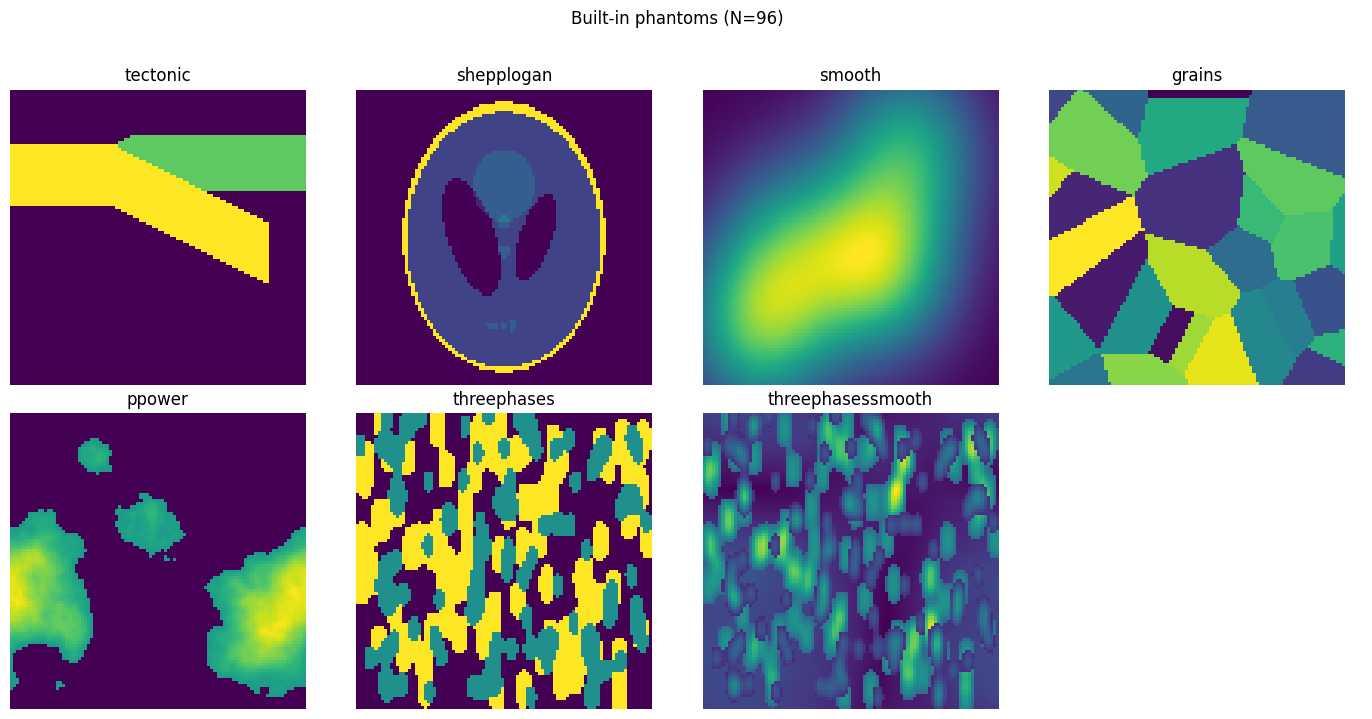

In [2]:
names = [
    'tectonic',
    'shepplogan',
    'smooth',
    'grains',
    'ppower',
    'threephases',
    'threephasessmooth',
]
N = 96

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.ravel()

for idx, name in enumerate(names):
    im = phantom_gallery(name, N, seed=42)
    assert im.shape == (N, N)
    assert im.min() >= -1e-12
    assert im.max() <= 1 + 1e-12
    axes[idx].imshow(im, vmin=0, vmax=1)
    axes[idx].set_title(name)
    axes[idx].axis('off')

axes[-1].axis('off')
fig.suptitle('Built-in phantoms (N=96)', y=1.02)
plt.tight_layout()


## Seed reproducibility for stochastic phantoms

In [3]:
stochastic_names = ['grains', 'ppower', 'threephases', 'threephasessmooth']
N = 64

for name in stochastic_names:
    im1 = phantom_gallery(name, N, seed=123)
    im2 = phantom_gallery(name, N, seed=123)
    im3 = phantom_gallery(name, N, seed=124)
    same_seed_max_diff = float(np.abs(im1 - im2).max())
    diff_seed_mean_diff = float(np.abs(im1 - im3).mean())
    print(f'{name:16s} same-seed max diff={same_seed_max_diff:.3e}, different-seed mean diff={diff_seed_mean_diff:.3e}')
    np.testing.assert_allclose(im1, im2, atol=0, rtol=0)


grains           same-seed max diff=0.000e+00, different-seed mean diff=3.805e-01
ppower           same-seed max diff=0.000e+00, different-seed mean diff=2.681e-01
threephases      same-seed max diff=0.000e+00, different-seed mean diff=4.666e-01
threephasessmooth same-seed max diff=0.000e+00, different-seed mean diff=1.991e-01


## `smooth`: vary `num_gaussians`

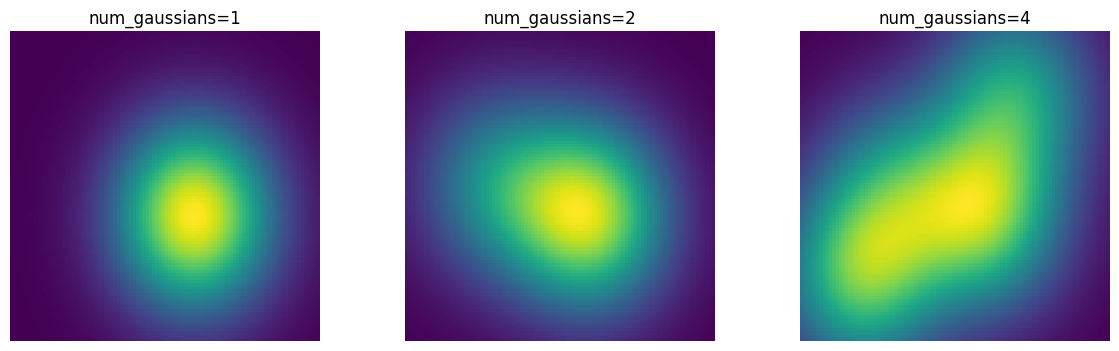

In [4]:
N = 96
vals = [1, 2, 4]
fig, axes = plt.subplots(1, len(vals), figsize=(12, 3.6))
for ax, g in zip(axes, vals):
    im = phantom_gallery('smooth', N, num_gaussians=g)
    ax.imshow(im, vmin=0, vmax=1)
    ax.set_title(f'num_gaussians={g}')
    ax.axis('off')
plt.tight_layout()


## `grains`: vary `num_cells`

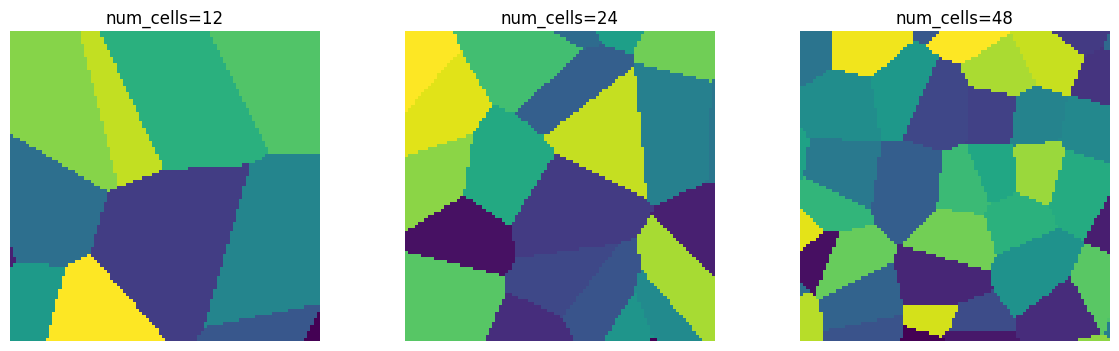

In [5]:
N = 96
vals = [12, 24, 48]
fig, axes = plt.subplots(1, len(vals), figsize=(12, 3.6))
for ax, c in zip(axes, vals):
    im = phantom_gallery('grains', N, seed=7, num_cells=c)
    ax.imshow(im, vmin=0, vmax=1)
    ax.set_title(f'num_cells={c}')
    ax.axis('off')
plt.tight_layout()


## `ppower`: vary `rel_nonzero` and `smoothness`

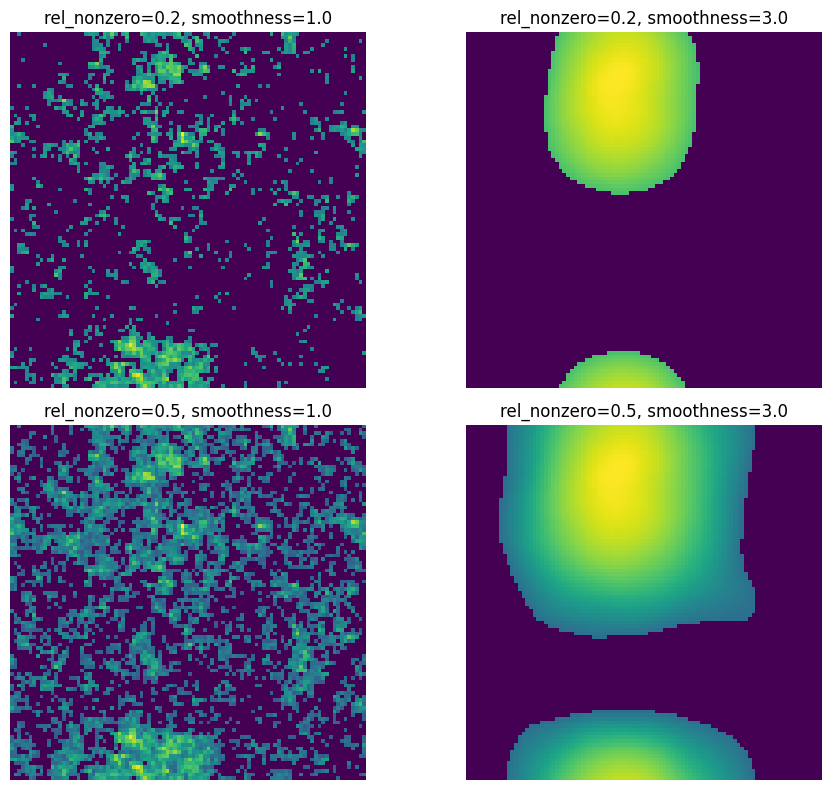

In [6]:
N = 96
settings = [
    (0.2, 1.0),
    (0.2, 3.0),
    (0.5, 1.0),
    (0.5, 3.0),
]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, (rnz, smoothness) in zip(axes.ravel(), settings):
    im = phantom_gallery('ppower', N, seed=9, rel_nonzero=rnz, smoothness=smoothness)
    ax.imshow(im, vmin=0, vmax=1)
    ax.set_title(f'rel_nonzero={rnz}, smoothness={smoothness}')
    ax.axis('off')
plt.tight_layout()


## `threephases` and `threephasessmooth` parameters

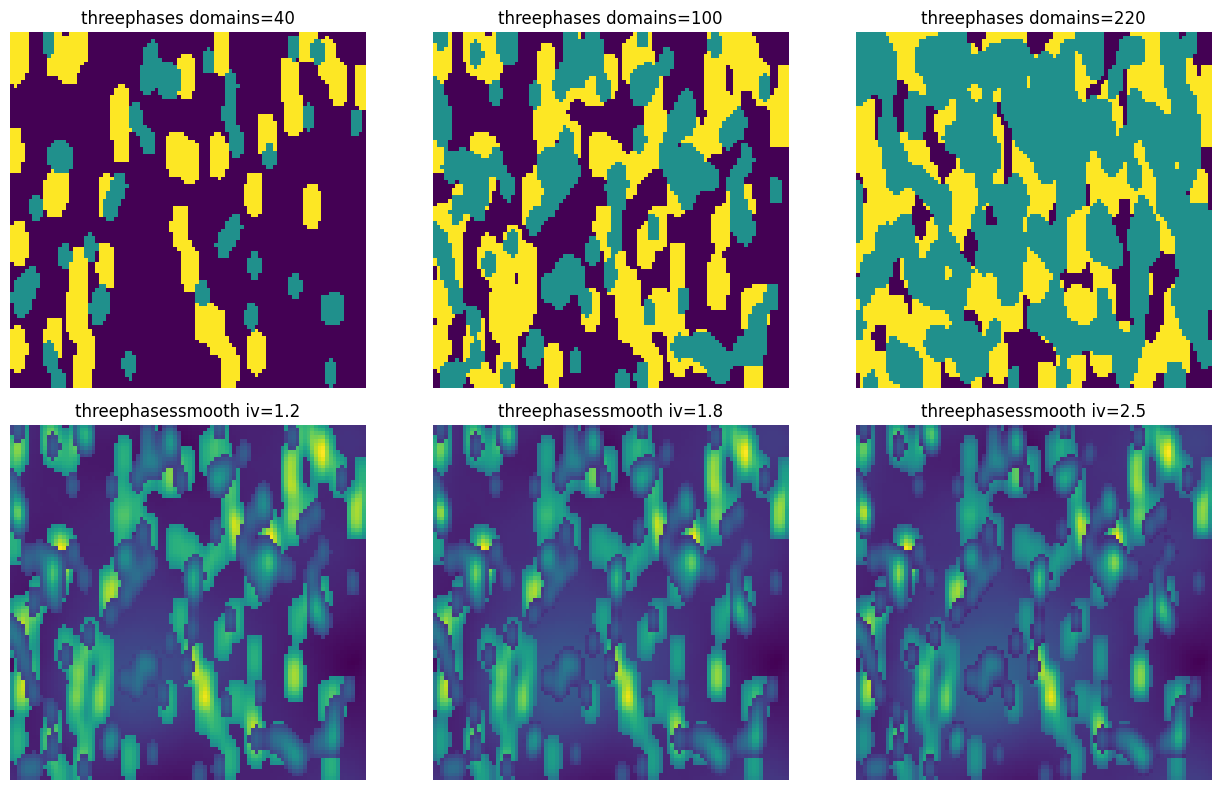

In [7]:
N = 96
domains = [40, 100, 220]
intensities = [1.2, 1.8, 2.5]

fig, axes = plt.subplots(2, 3, figsize=(13, 8))
for j, d in enumerate(domains):
    im = phantom_gallery('threephases', N, seed=11, num_domains=d)
    axes[0, j].imshow(im, vmin=0, vmax=1)
    axes[0, j].set_title(f'threephases domains={d}')
    axes[0, j].axis('off')

for j, iv in enumerate(intensities):
    im = phantom_gallery('threephasessmooth', N, seed=11, num_domains=100, intensity_variation=iv)
    axes[1, j].imshow(im, vmin=0, vmax=1)
    axes[1, j].set_title(f'threephasessmooth iv={iv}')
    axes[1, j].axis('off')

plt.tight_layout()


## Use a generated phantom in `prseismic`

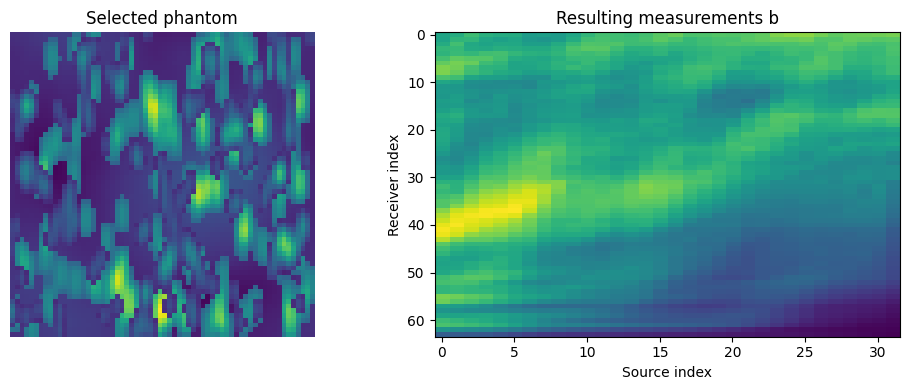

In [8]:
N = 64
im = phantom_gallery('threephasessmooth', N, seed=4, num_domains=120, intensity_variation=2.0)
prob = prseismic(N, phantom=im, wave_model='ray', s=32, p=64)
b_img = prob.b.reshape((64, 32), order='F')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(im, vmin=0, vmax=1)
axes[0].set_title('Selected phantom')
axes[0].axis('off')

axes[1].imshow(b_img, aspect='auto')
axes[1].set_title('Resulting measurements b')
axes[1].set_xlabel('Source index')
axes[1].set_ylabel('Receiver index')
plt.tight_layout()
